### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt                            #standard libraries
import sklearn.datasets

from sklearn.model_selection import StratifiedShuffleSplit #to ensure that datasets have the proportions
from sklearn.cluster import KMeans                         #used for classification/dimensionality reduction/extension
from sklearn.metrics import silhouette_score               #for K-means model selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline                       
from sklearn.model_selection import GridSearchCV           #for hyperparameter tuning
from sklearn.base import BaseEstimator, TransformerMixin   #for writing cutstom transformers in pipelines
from sklearn.decomposition import PCA                      #for yet another dimensionality reduction

RANDOM = 42                                                #setting RNG

### Fetching and getting familiar with the dataset

In [2]:
data = sklearn.datasets.fetch_olivetti_faces()

In [3]:
data.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [4]:
print(data["DESCR"])

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

In [5]:
data.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

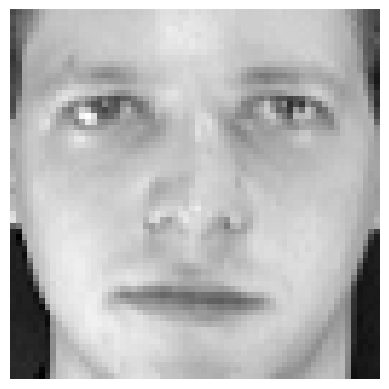

In [6]:
plt.imshow(data["images"][0].reshape((64,64)), cmap = "gray")   #data is flattened, it has to be reshaped in order to plot
plt.axis("off")
plt.show()

### Splitting dataset

In [7]:
X = data.data
y = data.target

In [8]:
split_test = StratifiedShuffleSplit(n_splits = 1, test_size=80, random_state=RANDOM)  #There are many classes and random sampling
                                                                                      #could lead to significant sampling errors
                                                                                      #therefore stratified method is used
for train_index, test_index in split_test.split(X, y):
    X_train, y_train = X[train_index,:], y[train_index]
    X_test, y_test = X[test_index,:], y[test_index]

In [9]:
print(sorted(y_test))  #exactly 2 instances of each person

[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39]


### Reducing dataset with PCA to speed up computations

In [10]:
pca = PCA(0.99)                
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
pca.n_components_

222

### KMeans clustering of faces

In [11]:
scale = list(range(2,122, 3))
models = []
score_k = []
inertia_k = []
for k in scale:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=RANDOM)
    kmeans.fit(X_train_pca)
    models.append(kmeans)
    score_k.append(silhouette_score(X_train_pca, kmeans.labels_))
    inertia_k.append(kmeans.inertia_)

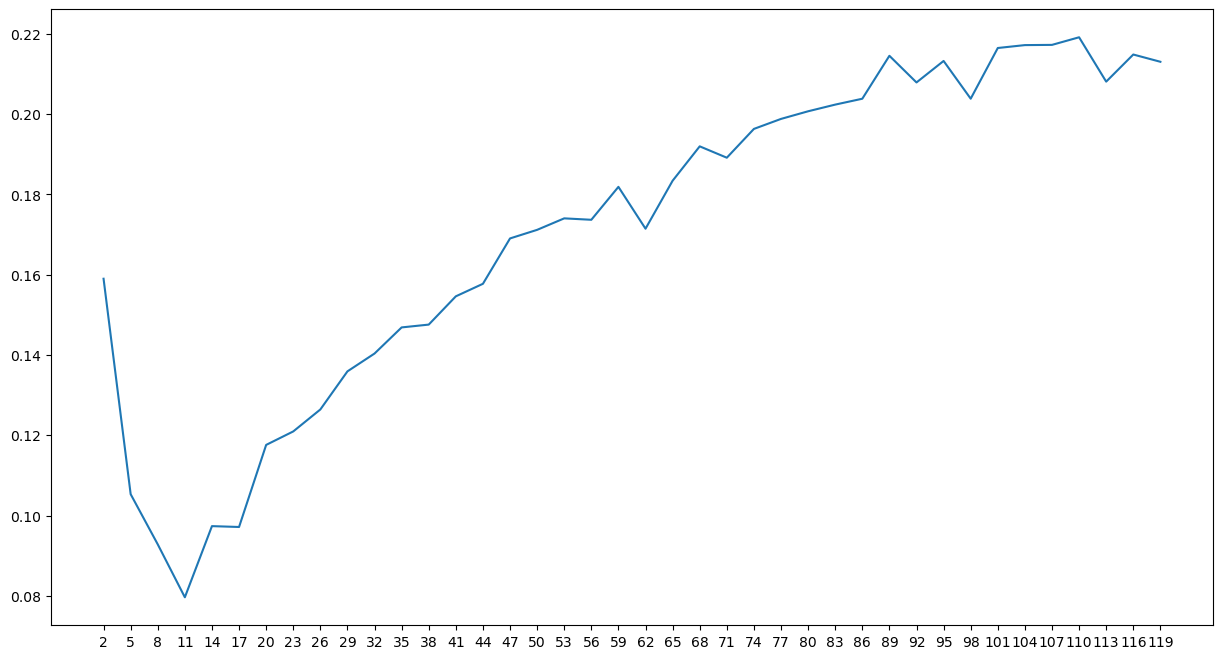

In [12]:
plt.figure(figsize=(15, 8))
plt.plot(scale, score_k)
plt.xticks(scale)
plt.show()

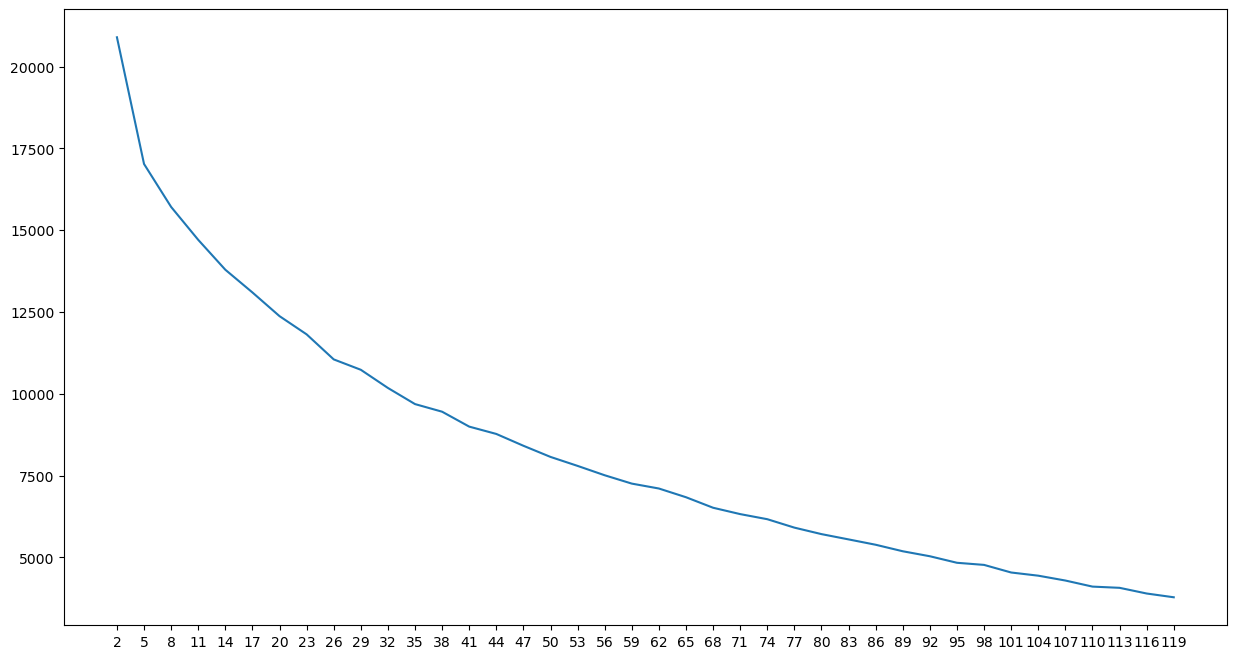

In [13]:
plt.figure(figsize=(15, 8))
plt.plot(scale, inertia_k)
plt.xticks(scale)
plt.show()

##### Basing on the silhouette score (as there is no "elbow"), the optimal number of clusters is somewhere between 101 and 110

In [14]:
score_k[-5], models[-5]

(0.2172548, KMeans(n_clusters=107, n_init=10, random_state=42))

In [15]:
model_kmeans = models[-5] #choosing model with 107 clusters

In [16]:
y_pred = model_kmeans.predict(X_train_pca) #prediction is used below for visualization

Cluster 0


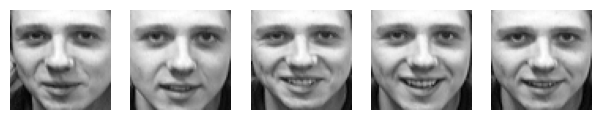

Cluster 1


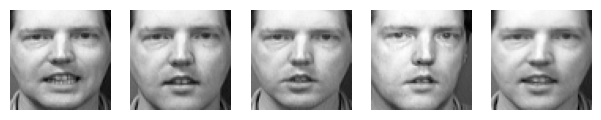

Cluster 2


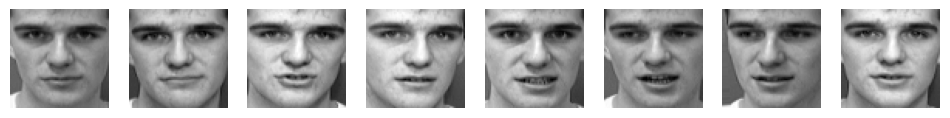

Cluster 3


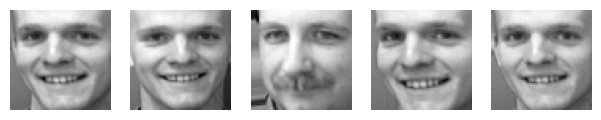

Cluster 4


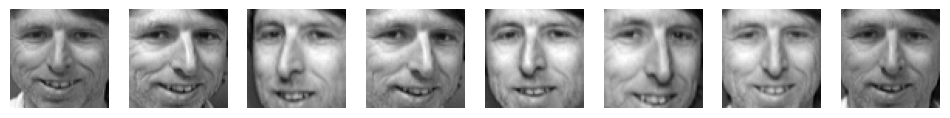

Cluster 5


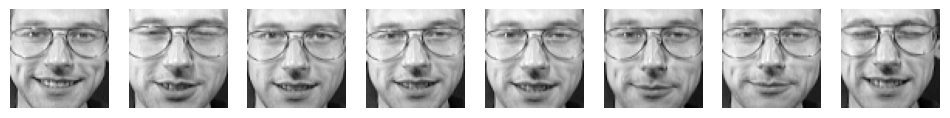

Cluster 6


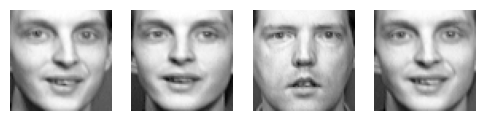

Cluster 7


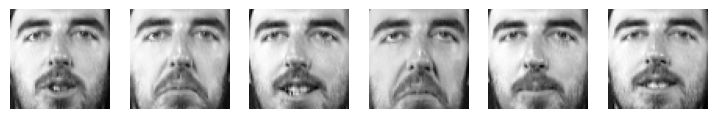

Cluster 8


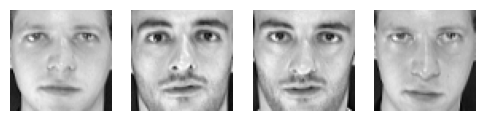

Cluster 9


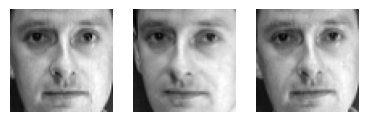

In [17]:
all = max(y_pred)                                   #there are many clusters, but desired can be set to all
desired = 10
for i in range(min(all, desired)):
        num_row = 1
        num_col = (y_pred == i).sum()
        print("Cluster {}".format(i))

        if num_col == 1:
                plt.figure(figsize = (num_col*1.5, num_row * 1.8))
                plt.imshow(X_train[np.where(y_pred == i)].reshape((64,64)), cmap = "gray")
                plt.axis("off")
                plt.show()

        else:
                fig, ax = plt.subplots(num_row, num_col, figsize = (num_col*1.5, num_row * 1.8))

                for num, image in enumerate(X_train[np.where(y_pred == i)]):
                        ax[num].axis("off")
                        ax[num].imshow(image.reshape((64,64)), cmap = "gray")
                plt.show()


### As can be seen above, Kmeans does pretty decent job clustering faces, it can have potential in extending dataset

### Let's try to build a classifier on PCA dataset without using Kmeans at all

In [18]:
rf = RandomForestClassifier(random_state=RANDOM)

rf.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=42)

In [19]:
rf.score(X_test_pca, y_test)

0.925

### Baseline accuracy is ~92%

### Below is a model based solely on KMeans transformation (it relies on kmeans "transform" method, calculating distance of an instance from each cluster centroid)

In [20]:
pipeline = Pipeline([
                    ("kmeans", model_kmeans),
                    ("rf", RandomForestClassifier(random_state = RANDOM)),
])

pipeline.fit(X_train_pca, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=107, n_init=10, random_state=42)),
                ('rf', RandomForestClassifier(random_state=42))])

In [21]:
pipeline.score(X_test_pca, y_test)

0.725

### Out of the box accuracy is much lower, let's try with hyperparameter tuning

In [22]:
params = {
    "kmeans__n_clusters" : list(range(60, 130, 5))
}

search = GridSearchCV(pipeline, param_grid= params, scoring = "accuracy", verbose = 0, cv = 5)

In [23]:
search.fit(X_train_pca, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=107, n_init=10,
                                               random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'kmeans__n_clusters': [60, 65, 70, 75, 80, 85, 90, 95,
                                                100, 105, 110, 115, 120, 125]},
             scoring='accuracy')

In [24]:
search.score(X_test_pca, y_test)

0.8125

### A little better, but still worse

### Let's try to append KMeans features to the orginal dataset, this time with immediate hyperparameter tuning

In [25]:
class KMeansAppender(BaseEstimator, TransformerMixin):       #custom transformation
    def __init__(self, n_clusters = 5, random_state = None, n_init = 10):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.random_state = random_state

    def fit(self, X, y = None):
        self.model = KMeans(n_clusters = self.n_clusters, n_init = self.n_init, random_state = self.random_state).fit(X) 
        return self

    def transform(self, X, y = None):
        return np.c_[X, self.model.transform(X)]

In [26]:
pipeline = Pipeline([
                    ("KMeansAppender", KMeansAppender()),
                    ("rf", RandomForestClassifier(random_state = RANDOM)),
])

In [27]:
params = {
    "KMeansAppender__n_clusters" : list(range(60, 130, 5)),
    "KMeansAppender__random_state" : [RANDOM]
}

search = GridSearchCV(pipeline, param_grid= params, scoring = "accuracy", verbose = 0, cv = 5)

In [28]:
search.fit(X_train_pca, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('KMeansAppender', KMeansAppender()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'KMeansAppender__n_clusters': [60, 65, 70, 75, 80, 85,
                                                        90, 95, 100, 105, 110,
                                                        115, 120, 125],
                         'KMeansAppender__random_state': [42]},
             scoring='accuracy')

In [29]:
search.best_estimator_.score(X_test_pca, y_test)

0.825

### Accuracy has improved but with comparison to baseline there is no improvement.